In [1]:
# 기본 라이브러리
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

# 주성분분석(Principal Analysis)을 하기위한 라이브러리
from sklearn.decomposition import PCA

# 파일 경로 확인용
import os
import glob

# .py 파일 가져오기
# import (폴더이름.)파일이름
import src.facenet as facenet
import src.align.detect_face as detect_face

In [2]:
# jupyter notebook 페이지에 그리기
%matplotlib inline

In [3]:
# 학습되어있는 모델을 로드하는 함수
#    입력: protobuf 파일(모델이 정의되어 있음)
#    리턴:
#        - single_image: 영상을 입력하는 placeholder (session.run feed_dict에 사용)
#        - embeddings: 네트워크의 출력 값, 512차원의 추출된 얼굴 특징 벡터

def load_model(pb_path, image_size=(160,160)):
    tf.reset_default_graph()
    
    single_image = tf.placeholder(tf.int32, (None,None,3))
    float_image = tf.cast(single_image, tf.float32)
    float_image = float_image / 255
    batch_image = tf.expand_dims(float_image, 0)
    resized_image = tf.image.resize(batch_image, image_size)
    
    phase_train = tf.placeholder_with_default(False, shape=[])
    
    input_map = {'image_batch':resized_image, 'phase_train':phase_train}
    model = facenet.load_model(pb_path, input_map)
    
    embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
    
    return single_image, embeddings

In [4]:
# 영상 경로를 입력박아 로드하고, return해주는 함수

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

In [5]:
# 두 벡터간의 거리를 계산하는 함수

def calc_distance(embedding1, embedding2):
    # Euclidian distance
    diff = np.subtract(embedding1, embedding2)
    dist = np.sum(np.square(diff),0)
    
    return dist

In [6]:
## 모델 및 세션 선언
single_image, embeddings = load_model("./models/20180402-114759.pb")

sess = tf.Session()

Model filename: ./models/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.


In [7]:
## 내 얼굴의 특징벡터(embedding)추출

path_me = glob.glob("./data/faces/me/*")

embed_me = []

for path in path_me:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image:img})
    result = result[0]
    embed_me.append(result)
    
embed_me = np.array(embed_me)
print(embed_me.shape)

(15, 512)


In [8]:
## 다른 사람 얼굴의 특징벡터(embedding)추출

path_other1 = glob.glob("./data/faces/other1/*")

embed_other1 = []

for path in path_other1:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image:img})
    result = result[0]
    embed_other1.append(result)
    
embed_other1 = np.array(embed_other1)
print(embed_other1.shape)

(5, 512)


In [9]:

path_other2 = glob.glob("./data/faces/other2/*")

embed_other2 = []

for path in path_other2:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image:img})
    result = result[0]
    embed_other2.append(result)
    
embed_other2 = np.array(embed_other2)
print(embed_other2.shape)

(22, 512)


In [10]:
# 얼굴 특징벡터 간의 거리 확인
# 내얼굴 1과 내얼굴 2의 거리 확인
print(calc_distance(embed_me[0], embed_me[1]))

# 내얼굴 1과 다른사람 얼굴 1의 거리 확인
print(calc_distance(embed_me[0], embed_other1[0]))

1.0721481
2.379059


In [11]:
# 기준이 되는 얼굴 임베딩 설정
base_embed = embed_me[0]

print("---------- 내 얼굴과의 거리 ----------")
# 얼굴 0~N 까지 확인
for e in embed_me:
    print(calc_distance(base_embed, e))
    
print("\n\n")
print("---------- 다른 사람 얼굴과의 거리 ----------")
# 다른 사람1, 2를 묶어서 확인
embed_others = np.concatenate((embed_other1, embed_other2), axis=0)
for e in embed_others:
    print(calc_distance(base_embed, e))

---------- 내 얼굴과의 거리 ----------
0.0
1.0721481
1.5417243
1.4501164
1.239556
1.2114099
1.2355279
1.200953
1.1977113
1.3168582
1.2873197
1.2917688
1.2180538
1.1691065
1.3246382



---------- 다른 사람 얼굴과의 거리 ----------
2.379059
2.1685808
2.1127176
2.1760237
2.3625536
1.4969604
1.509634
1.8577082
1.5724509
1.8361936
1.6305852
1.6051273
1.7497635
1.7572035
1.8314309
1.6671582
1.4901332
1.5544488
1.8002155
1.7106433
1.7155133
1.7919309
1.6463647
1.6955647
1.7551303
1.7679522
1.833136


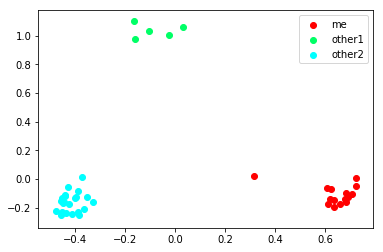

In [12]:
## PCA를 사용한 시각화(512->2차원으로 감소)
# 모든 임베딩을 묶음
all_embeddings = np.concatenate((embed_me, embed_other1, embed_other2), axis=0)

# PCA 클래스 선언 (n_component는 축소할 차원을 의미)
pca = PCA(n_components=2)

# PCA 계산 (이후 pca.transform 함수를 사용하여 512차원을 2차원으로 축소)
pca.fit(all_embeddings)

# PCA를 사용하여 차원 축소
xy_me = pca.transform(embed_me)
xy_other1 = pca.transform(embed_other1)
xy_other2 = pca.transform(embed_other2)

ax = plt.figure()

sc1 = plt.scatter(xy_me[:,0], xy_me[:,1], color=(1, 0, 0))
sc2 = plt.scatter(xy_other1[:,0], xy_other1[:,1], color=(0, 1, 0.4))
sc3 = plt.scatter(xy_other2[:,0], xy_other2[:,1], color=(0, 1, 1))

plt.legend([sc1,sc2,sc3], ["me", "other1", "other2"], loc="upper right")

In [13]:
## 내 얼굴인지 분류
# 영상 경로를 자유롭게 수정
x_path = "./data/faces/me/video_bc2_short0_0.jpg"

image_x = load_image(x_path)
result_x = sess.run(embeddings, feed_dict={single_image:image_x})
result_x = result_x[0]

distance_th = 1.2 # 거리가 얼마 미만이여야 나로 분류할지

distance1 = calc_distance(embed_me[0], result_x)
distance2 = calc_distance(embed_me[3], result_x)

avg_distance = (distance1+distance2) / 2
print("distance:", avg_distance)

if(avg_distance < distance_th):
    print(x_path, "는 내 얼굴입니다")
else:
    print(x_path, "는 내 얼굴이 아닙니다")

distance: 0.7783137559890747
./data/faces/me/video_bc2_short0_0.jpg 는 내 얼굴입니다


In [14]:
## 함수정의
# 단일 RGB영상과 pre-trained 네트워크(P/R/0 net)를 입력받아
#   1. face detection
#   2. crop (margin 추가)
#   3. resize 하고,
#  검출된 얼굴 영상들의 리스트를 반환하는 함수

def crop_faces(image, pnet, rnet, onet):
    # face detection 관현 파라미터
    
    minsize = 20 #minimum size of face
    threshold = [0.6, 0.7, 0.7] # three step's threshold
    factor = 0.709 # scale factor
    
    # crop 관련 파라미터
    margin = 44 # 상하좌우 여백
    image_size = 160 # resize(scaling) 크기
    
    h,w,_ = np.shape(image)
    
    # 얼굴 검출
    bounding_boxes, points = detect_face.detect_face(image, minsize, pnet, rnet, onet, threshold, factor)
    # bounding_boxes: 검출된 사각형 영역,
    #                 [x1,y1,x2,y2,확률]로 이루어진 리스트
    # points: 검출된 얼굴의 주요 landmark,
    #         [x1,x2,x3,x4,x5,y1,y2,y3,y4,y5]로 이루어진 리스트
    
    faces = []
    for box in bounding_boxes:
        box = np.int32(box)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(box[0]-margin/2, 0)
        bb[1] = np.maximum(box[1]-margin/2, 0)
        bb[2] = np.minimum(box[2]+margin/2, w)
        bb[3] = np.minimum(box[3]+margin/2, h)
        cropped = image[bb[1]:bb[3],bb[0]:bb[2],:]
        scaled = cv2.resize(cropped, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
        
        faces.append(scaled)
    
    return faces, bounding_boxes

In [15]:
## 학습되어 있는 detection 모델 로드
pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


영상에서 검출된 얼굴의 개수: 1


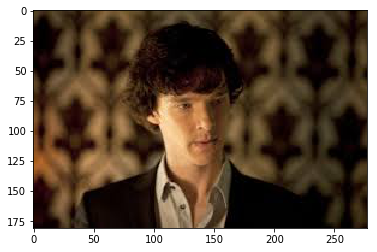

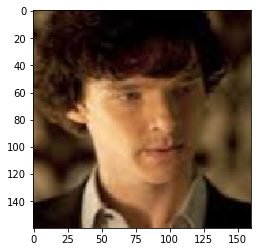

In [16]:
## 얼굴 검출 및 출력
image = load_image("./data/images/me/bc1.jpg")
plt.figure()
plt.imshow(image)

faces, bounding_boxes = crop_faces(image, pnet, rnet, onet)
print("영상에서 검출된 얼굴의 개수:", len(faces))

plt.figure()
plt.imshow(faces[0])

In [17]:
## bounding box 확인 및 그리기
print(bounding_boxes[0])

[100.79861677  53.57836652 165.27135366 132.32560253   0.99986064]


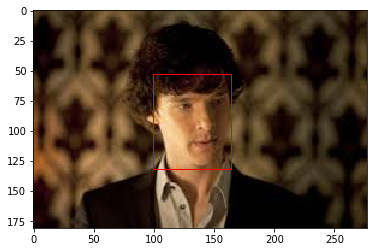

In [18]:
squared_img = image.copy()
for box in bounding_boxes:
    box = np.int32(box)
    p1 = (box[0], box[1])
    p2 = (box[2], box[3])
    # if 내얼굴 == 파란색
    # else == 빨간색
    cv2.rectangle(squared_img, p1, p2, color=(255,0,0))
    
plt.imshow(squared_img)